In [4]:
%pip install git+https://github.com/FacePerceiver/facer.git@main

  Cloning https://github.com/FacePerceiver/facer.git (to revision main) to /tmp/pip-req-build-ntfj4g6y
  Running command git clone --filter=blob:none --quiet https://github.com/FacePerceiver/facer.git /tmp/pip-req-build-ntfj4g6y
  Encountered 16 file(s) that should have been pointers, but weren't:
        samples/data/fire.webp
        samples/data/girl.jpg
        samples/data/sideface.jpg
        samples/data/twogirls.jpg
        samples/data/weirdface.jpg
        samples/data/weirdface2.jpg
        samples/data/weirdface3.jpg
        samples/download.ipynb
        samples/example_output/alignment.png
        samples/example_output/detect.png
        samples/example_output/parsing.png
        samples/face_alignment.ipynb
        samples/face_attribute.ipynb
        samples/face_detect.ipynb
        samples/face_parsing.ipynb
        samples/transform.ipynb
  Resolved https://github.com/FacePerceiver/facer.git to commit b2e4fcb94fa8db7cff1a053b6c6441131274c074
  Preparing metadata (se

In [25]:
pwd

'/home/dmarx/projects/whats-in-a-name'

In [2]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
import facer 


face_detector = facer.face_detector('retinaface/mobilenet', device=device)
#face_parser = facer.face_parser('farl/lapa/448', device=device) # optional "farl/celebm/448"
model_id = 'farl/celebm/448'
face_parser = facer.face_parser(model_id, device=device)

In [33]:
import numpy as np
from PIL import Image
from pathlib import Path
import gc
import random

gc.collect()
torch.cuda.empty_cache()

n = 24
im_paths = [str(fp.absolute()) for i,fp in enumerate(Path("images/a_photo_of_billy_portrait_photography_full_color_face_full_frame/").glob("*.png"))]
im_paths = random.sample(im_paths, k=n)
#im_paths

images = []

for path in im_paths:
    #facer.read_hwc
    image = Image.open(path)
    np_image = np.array(image.convert('RGB'))
    image_t = torch.from_numpy(np_image)
    image_t = image_t.unsqueeze(0).permute(0, 3, 1, 2)
    images.append(image_t)

images_t = torch.cat(images).to(device)
print(images_t.shape)
# takes almost no time to load images from disk compared to time it would take to generate an equivalent size batch of samples. pre-generate images for sure.

torch.Size([24, 3, 512, 512])


In [34]:
import time

# N | T
# 4 | 0.05 | 9.7
# 8 | 4.1  | 10.9
# 12 | 6.27
# 16 | 24
# 20 | 10.39 | 40.8
# 24 | 12.34
#
# 32 | 15.98 | 16.9 | 69 | 53
# 40 | 56 | 61
# 44 | OOM
# 48 | 86 
# 64 | OOM

#m=1 # grow image list for stress testing
#images_t = torch.cat(images*m).to(device)
print(images_t.shape)

st = time.time()
last = st

with torch.inference_mode():
    faces = face_detector(images_t)

et = time.time()
print(f"elapsed: {et-last}")
last = et

#facer.show_bchw(facer.draw_bchw(images_t, faces))

# if anything runs slow, seems to be this
# now.... why?
with torch.inference_mode():
    faces_parsed = face_parser(images_t, faces)

et = time.time()
print(f"elapsed: {et-last}")
print(f"total elapsed: {et-st}")

#facer.show_bchw(facer.draw_bchw(images_t, faces)) # ah, the `faces` object is being mutated AND returned. got it.

torch.Size([24, 3, 512, 512])
elapsed: 0.09109258651733398
elapsed: 15.987348556518555
total elapsed: 16.07844114303589


In [29]:
faces.keys()        # dict_keys(['rects', 'points', 'scores', 'image_ids', 'seg'])
faces_parsed.keys() # dict_keys(['rects', 'points', 'scores', 'image_ids', 'seg'])

dict_keys(['rects', 'points', 'scores', 'image_ids', 'seg'])

In [30]:
seg_logits = faces_parsed['seg']['logits']
seg_probs = seg_logits.softmax(dim=1)  # nfaces x nclasses x h x w
n_classes = seg_probs.size(1)
vis_seg_probs = seg_probs.argmax(dim=1).float()/n_classes*255
vis_img = vis_seg_probs.sum(0, keepdim=True)

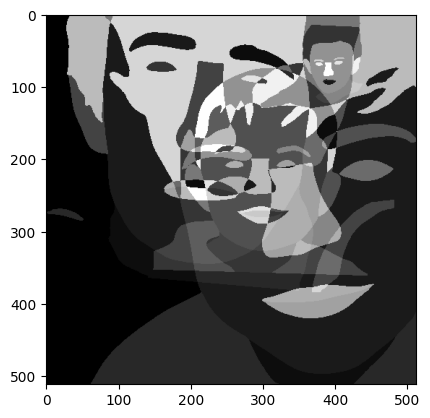

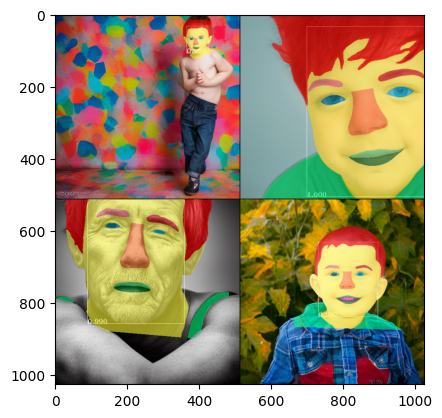

In [31]:
# lol
#facer.show_bhw(vis_img)
facer.show_bhw(vis_img)
facer.show_bchw(facer.draw_bchw(images, faces))

In [ ]:
# https://github.com/FacePerceiver/facer/blob/b2e4fcb94fa8db7cff1a053b6c6441131274c074/facer/draw.py#L149-L159

    #     if tag == 'seg':
    #         label_names = batch_content['label_names']
    #         for seg_logits in batch_content['logits']:
    #             # content: nclasses x h x w
    #             seg_probs = seg_logits.softmax(dim=0)
    #             seg_labels = seg_probs.argmax(dim=0).cpu().numpy()
    #             image = (_blend_labels(image.astype(np.float32) /
    #                      255, seg_labels,
    #                      label_names_dict=label_names) * 255).astype(dtype)

    # return torch.from_numpy(image).to(device=device)

# https://github.com/FacePerceiver/facer/blob/b2e4fcb94fa8db7cff1a053b6c6441131274c074/facer/draw.py#L45

In [20]:
faces['seg'].keys()

dict_keys(['logits', 'label_names'])

In [33]:
faces['seg']['label_names']

# class_idx - notes
# * 0 - head
# * 1 - face skin (sans nose)
# * 6 - nose
# * 2,3 - eyebrows
# * 4,5 - eyes
# * 10 - hair

['background',
 'neck',
 'face',
 'cloth',
 'rr',
 'lr',
 'rb',
 'lb',
 're',
 'le',
 'nose',
 'imouth',
 'llip',
 'ulip',
 'hair',
 'eyeg',
 'hat',
 'earr',
 'neck_l']

Downloading: "https://github.com/FacePerceiver/facer/releases/download/models-v1/face_parsing.farl.celebm.main_ema_181500_jit.pt" to /home/dmarx/.cache/torch/hub/checkpoints/face_parsing.farl.celebm.main_ema_181500_jit.pt
100%|████████████████████████████████████████| 617M/617M [00:57<00:00, 11.3MB/s]


0.4075748920440674


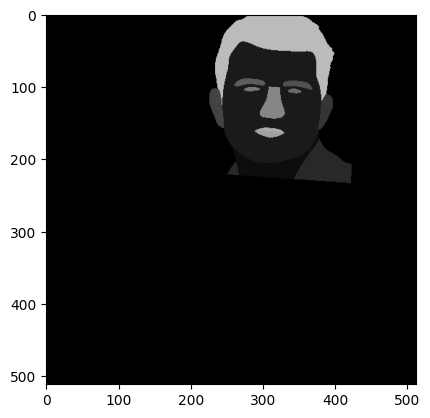

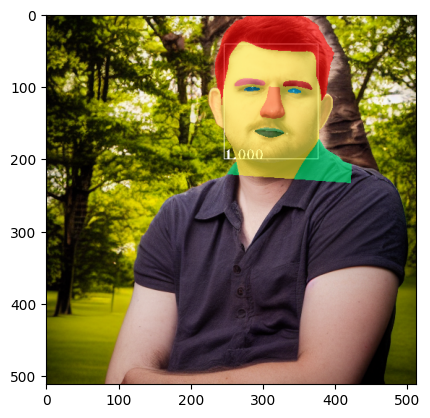

In [23]:
# import torch
# import facer

# import time

# device = 'cuda' if torch.cuda.is_available() else 'cpu'

# #image = facer.hwc2bchw(facer.read_hwc('data/twogirls.jpg')).to(device=device)  # image: 1 x 3 x h x w
# impath="images/a_photo_of_billy_portrait_photography_full_color_face_full_frame/1695540450_11.png"
# image = facer.hwc2bchw(facer.read_hwc(impath)).to(device=device)  # image: 1 x 3 x h x w


# face_detector = facer.face_detector('retinaface/mobilenet', device=device)
# #face_parser = facer.face_parser('farl/lapa/448', device=device) # optional "farl/celebm/448"
# model_id = 'farl/celebm/448'
# face_parser = facer.face_parser(model_id, device=device)

# ###############

# st = time.time()
# with torch.inference_mode():
#     faces = face_detector(image)

# with torch.inference_mode():
#     faces = face_parser(image, faces)

# ###############

# seg_logits = faces['seg']['logits']
# seg_probs = seg_logits.softmax(dim=1)  # nfaces x nclasses x h x w
# n_classes = seg_probs.size(1)
# vis_seg_probs = seg_probs.argmax(dim=1).float()/n_classes*255
# vis_img = vis_seg_probs.sum(0, keepdim=True)

# et = time.time()
# print(et-st) # .36s for batch_size=1

# facer.show_bhw(vis_img)
# facer.show_bchw(facer.draw_bchw(image, faces))

0


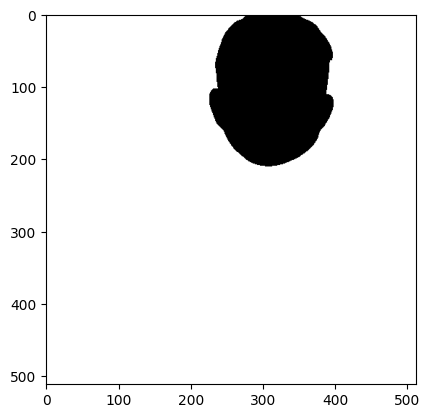

1


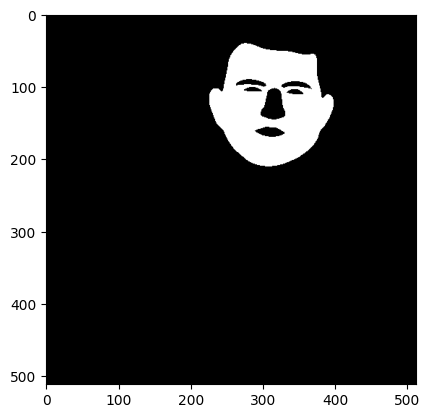

2


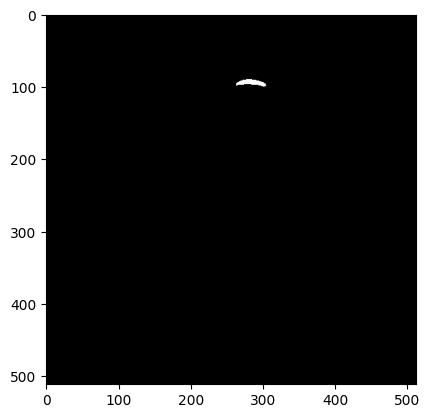

3


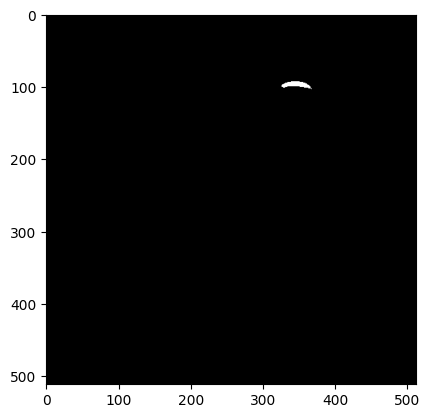

4


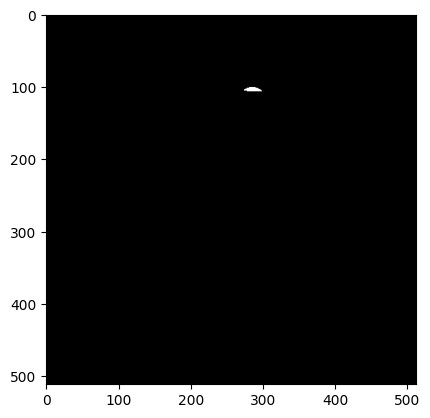

5


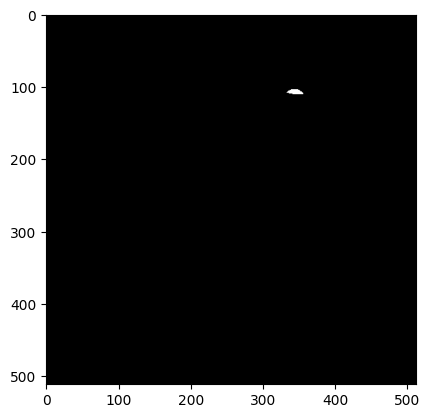

6


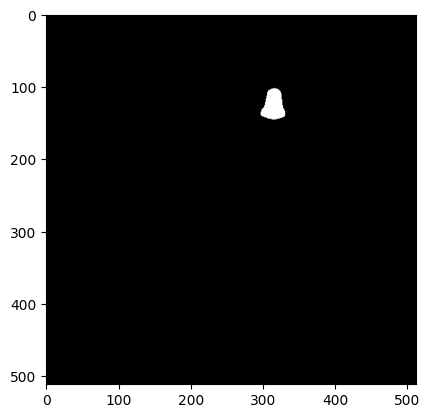

7


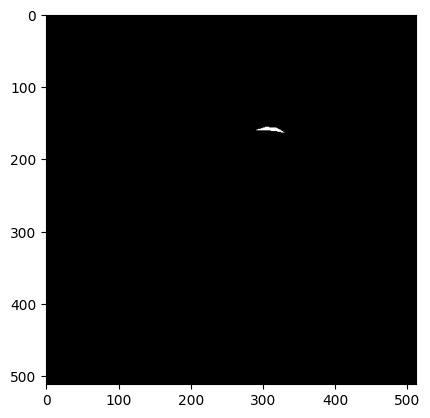

8


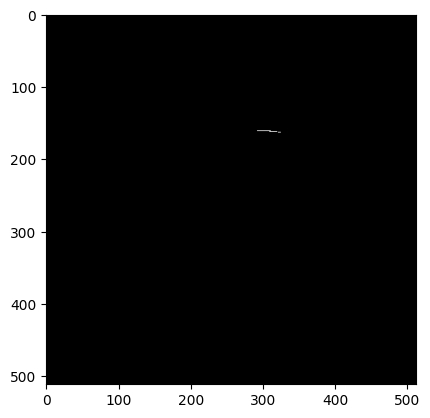

9


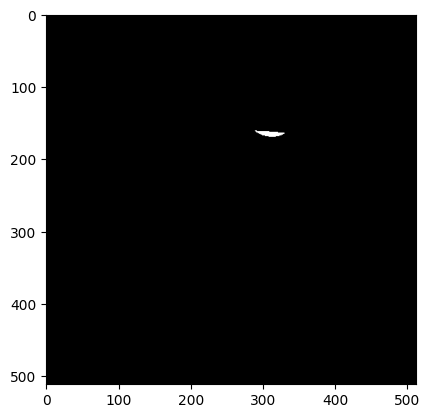

10


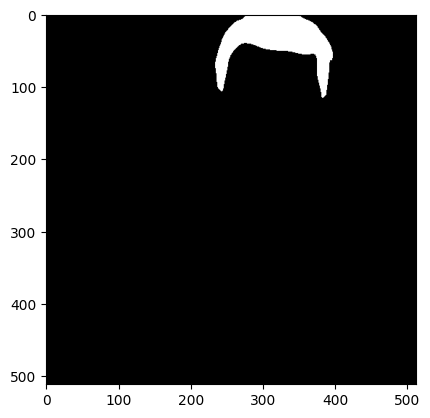

In [15]:
classification = seg_probs.argmax(dim=1)
for class_idx in range(n_classes):
    # vis_seg_probs = seg_probs.argmax(dim=1).float()/n_classes*255
    print(class_idx)
    vis_seg_probs = (classification == class_idx).float()
    vis_seg_probs*=255.
    vis_img = vis_seg_probs.sum(0, keepdim=True)
    facer.show_bhw(vis_img)

# class_idx - notes
# * 0 - head
# * 1 - face skin (sans nose)
# * 6 - nose
# * 2,3 - eyebrows
# * 4,5 - eyes
# * 10 - hair